## K2TranPix tester

In [2]:
#from ipywidgets import interact, interactive, fixed, interact_manual
#import ipywidgets as widgets
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from astropy.io import fits
from glob import glob

from scipy.signal import convolve2d
from scipy.ndimage.filters import convolve
from astropy.wcs import WCS
from tqdm import tnrange, tqdm_notebook
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)
#%matplotlib inline
%matplotlib notebook

In [9]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

from scipy.signal import convolve2d
from scipy.signal import deconvolve
from scipy.ndimage.filters import convolve

from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

from glob import glob
import os

from tqdm import tnrange, tqdm_notebook
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)

def MinThrustframe(data,thrust):
    mean = np.nanmean(data[thrust+1],axis = 0)
    std = np.nanstd((data[thrust+1] - mean), axis = (1,2))
    Framemin = np.where(std == np.nanmin(abs(std)))[0][0]
    return thrust[Framemin]+1

def DriftKiller(data,thrust):
    # The right value choice here is a bit ambiguous, though it seems that typical variations are <10.
    Drift = (abs(data[thrust+1]-data[thrust-1]) < 10)*1.0 
    Drift[Drift == 0] = np.nan
    j = 0
    for i in range(len(thrust)):
        data[j:thrust[i]] = data[j:thrust[i]]*Drift[i]
        j = thrust[i]
    return data

def FindMinFrame(data):
    # Finding the reference frame
    n_steps = 12
    std_vec = np.zeros(n_steps)
    for i in range(n_steps):
        std_vec[i] = np.nanstd(data[i:-n_steps+i:n_steps,:,:] - data[i+n_steps*80,:,:])
    Framemin = np.where(std_vec==np.nanmin(std_vec))[0][0]
    return Framemin

def ObjectMask(datacube,Framemin):
    # Make a mask of the target object, using the reference frame 
    Mask = datacube[Framemin,:,:]/(np.nanmedian(datacube[Framemin,:,:])+np.nanstd(datacube[Framemin,:,:]))
    Mask[Mask>=1] = np.nan
    Mask[Mask<1] = 1
    # Generate a second mask from remainder of the first. This grabs the fainter pixels around known sources
    Maskv2 = datacube[Framemin,:,:]*Mask/(np.nanmedian(datacube[Framemin,:,:]*Mask)+np.nanstd(datacube[Framemin,:,:]*Mask))
    Maskv2[Maskv2>=1] = np.nan
    Maskv2[Maskv2<1] = 1
    return Maskv2

def EventSplitter(events,Times,Masks):
    Events = []
    times = []
    mask = []
    for i in range(len(events)):
        # Check if there are multiple transients
        Coincident = convolve(Masks[events[i]]*1, np.ones((3,3)), mode='constant', cval=0.0)
        positions = np.where(Coincident == Coincident.max())
        for p in range(len(positions[0])):
            eventmask = np.zeros((Masks.shape[1],Masks.shape[2]))
            eventmask[positions[0][p],positions[1][p]] = 1
            eventmask = convolve(eventmask,np.ones((3,3)),mode='constant', cval=0.0)
            Similar = np.where(np.nansum(Masks[Times[i][0]:Times[i][-1],:,:]*eventmask,axis = (1,2)) > 0)[0]
            if len(Similar) > 0:
                timerange = [Similar[0]+Times[i][0]-1,Similar[-1]+Times[i][0]+1]
                if len(timerange) > 1:
                    Events.append(events[i])
                    times.append(timerange)
                    mask.append(eventmask)

    return Events, times, mask

def Asteroid_fitter(Mask,Time,Data, plot = False):
    lc = np.nansum(Data*Mask,axis=(1,2))
    middle = np.where(np.nanmax(lc[Time[0]-1:Time[-1]+1]) == lc)[0][0]
    x = np.arange(middle-2,middle+2+1,1)
    x2 = np.arange(0,len(x),1)
    y = lc[[np.arange(middle-2,middle+2+1,1)]]
    p1, residual, _, _, _ = np.polyfit(x,y,2, full = True)
    p2 = np.poly1d(p1)
    maxpoly = np.where(np.nanmax(p2(x)) == p2(x))[0][0]
    if (residual < 5000) &  (abs(middle - x[maxpoly]) < 2):
        asteroid = True
        if plot == True:
            p2 = np.poly1d(p1)
            plt.figure()
            plt.plot(x,lc[x],'.')
            plt.plot(x,p2(x),'.')
            plt.ylabel('Counts')
            plt.xlabel('Time')
            plt.title('Residual = ' + str(residual))
            
    else:
        asteroid = False
        
    return asteroid 

def Smoothmax(interval,Lightcurve,qual):
    x = np.arange(interval[0],interval[1],1.)
    x[qual[interval[0]:interval[-1]]!=0] = np.nan 
    nbins = int(len(x)/5)
    y = np.copy(Lightcurve[interval[0]:interval[-1]])
    y[qual[interval[0]:interval[-1]]!=0] = np.nan
    
    if np.nansum(x) > 0:
        n, _ = np.histogram(x, bins=nbins,range=(np.nanmin(x),np.nanmax(x)))
        sy, _ = np.histogram(x, bins=nbins, weights=y,range=(np.nanmin(x),np.nanmax(x)))
        sy2, _ = np.histogram(x, bins=nbins, weights=y*y,range=(np.nanmin(x),np.nanmax(x)))
        mean = sy / n
        std = np.sqrt(sy2/n - mean*mean)

        xrange = np.linspace(np.nanmin(x),np.nanmax(x),len(x))
        y_smooth = np.interp(xrange, (_[1:] + _[:-1])/2, mean)
        y_smooh_error = np.interp(xrange, (_[1:] + _[:-1])/2, std)

        temp = np.copy(y)
        temp[y_smooh_error>10] =np.nan
        if np.nansum(temp) > 0:
            maxpos = np.where(temp == np.nanmax(temp))[0][0]+interval[0]
        else:
            maxpos = 0
        
    else:
        maxpos = 0
    return maxpos

def ThrusterElim(Events,Times,Masks,Firings,Quality,qual,Data):
    temp = []
    temp2 = []
    temp3 = []
    asteroid = []
    asttime = []
    astmask = []
    for i in range(len(Events)):
        Range = Times[i][-1] - Times[i][0]
        if (Range > 0) & (Range/Data.shape[0] < 0.8) & (Times[i][0] > 5): 
            begining = Firings[(Firings >= Times[i][0]-3) & (Firings <= Times[i][0]+1)]
            if len(begining) == 0:
                begining = Quality[(Quality >= Times[i][0]-1) & (Quality <= Times[i][0]+1)]
            end = Firings[(Firings >= Times[i][-1]-1) & (Firings <= Times[i][-1]+3)]
            if len(end) == 0:
                end = Quality[(Quality >= Times[i][-1]-1) & (Quality <= Times[i][-1]+1)]
            eventthrust = Firings[(Firings >= Times[i][0]) & (Firings <= Times[i][-1])]
            
            if (~begining.any() & ~end.any()) & (len(eventthrust) < 3):
                
                if Asteroid_fitter(Masks[i],Times[i],Data):
                    asteroid.append(Events[i])
                    asttime.append(Times[i])
                    astmask.append(Masks[i])
                else:
                    temp.append(Events[i])
                    temp2.append(Times[i])
                    temp3.append(Masks[i])

            elif len(eventthrust) >= 3:

                if begining.shape[0] == 0:
                    begining = 0
                else:
                    begining = begining[0]   
                if end.shape[0] == 0:
                    end = Times[i][-1] + 10
                else:
                    end = end[0]
                LC = np.nansum(Data*Masks[i], axis = (1,2))
                maxloc = Smoothmax(Times[i],LC,qual)

                if ((maxloc > begining) & (maxloc < end)): 
                    premean = np.nanmean(LC[eventthrust-1]) 
                    poststd = np.nanstd(LC[eventthrust+1])
                    postmean = np.nanmedian(LC[eventthrust+1])
                    Outsidethrust = Firings[(Firings < Times[i][0]) | (Firings > Times[i][-1]+20)]
                    Outsidemean = np.nanmedian(LC[Outsidethrust+1])
                    Outsidestd = np.nanstd(LC[Outsidethrust+1])
                    if  postmean > Outsidemean+2*Outsidestd:
                        print(postmean)
                        print(Outsidemean)
                        print(Outsidestd)
                        temp.append(Events[i])
                        temp2.append(Times[i])
                        temp3.append(Masks[i])


    events = np.array(temp)
    eventtime = np.array(temp2)
    eventmask = np.array(temp3)
    print(events)
    return events, eventtime, eventmask, asteroid, asttime, astmask

    events = np.array(temp)
    eventtime = np.array(temp2)
    eventmask = np.array(temp3)
    return events, eventtime, eventmask, asteroid, asttime, astmask


def pix2coord(x,y,mywcs):
    wx, wy = mywcs.wcs_pix2world(x, y, 0)
    return np.array([float(wx), float(wy)])

def Get_gal_lat(mywcs,datacube):
    ra, dec = mywcs.wcs_pix2world(int(datacube.shape[1]/2), int(datacube.shape[2]/2), 0)
    b = SkyCoord(ra=float(ra)*u.degree, dec=float(dec)*u.degree, frame='icrs').galactic.b.degree
    return b



In [12]:
'/Volumes/TOSHIBA EXt/K2/c6/212300000/16000/ktwo212316559-c06_lpd-targ.fits.gz'

'/Volumes/TOSHIBA EXt/K2/c6/212300000/16000/ktwo212316559-c06_lpd-targ.fits.gz'

In [65]:
'/Volumes/TOSHIBA EXt/K2/c6/212200000/67000/ktwo212267079-c06_lpd-targ.fits.gz'#

'/Volumes/TOSHIBA EXt/K2/c6/212200000/67000/ktwo212267079-c06_lpd-targ.fits.gz'

In [12]:
pixelfile = '/Volumes/TOSHIBA EXt/K2/c6/212200000/72000/ktwo212272599-c06_lpd-targ.fits.gz'
save = '/Users/ryanr/Documents/PhD/coding/Kepler/K2/'

try:
    
    hdu = fits.open(pixelfile)
    dat = hdu[1].data
    datacube = np.load('/Users/ryanr/Documents/PhD/coding/Kepler/pipelines/Injections/testdata.npy')#fits.ImageHDU(hdu[1].data.field('FLUX')[:]).data#np.copy(testdata)#
    if datacube.shape[1] > 1 and datacube.shape[2] > 1:
        print('in')
        time = dat["TIME"] + 2454833.0
        Qual = hdu[1].data.field('QUALITY')
        thrusters = np.where((Qual == 1048576) | (Qual == 1089568) | (Qual == 1056768) | (Qual == 1064960) | (Qual == 1081376) | (Qual == 10240) | (Qual == 32768) )[0]
        quality = np.where((Qual != 0))[0]
        #calculate the reference frame
        Framemin = FindMinFrame(datacube)
        # Apply object mask to data
        Mask = ObjectMask(datacube,Framemin)
        
        Maskdata = datacube*Mask
        #Maskdata[Maskdata<0] = 0 

        #Motion control
        #Conv = convolve2d(np.ma.masked_invalid(Mask).mask, np.ones((3,3)), mode="same")
        #Maskdata = Maskdata*(Conv < 2)

        # Make a mask for the object to use as a test to eliminate very bad pointings
        obj = np.ma.masked_invalid(Mask).mask
        objmed = np.nanmedian(datacube[thrusters+1]*obj,axis=(0))
        objstd = np.nanstd(datacube[thrusters+1]*obj,axis=(0))
        Maskdata[(np.nansum(datacube*obj,axis=(1,2)) < np.nansum(objmed-2*objstd)),:,:] = np.nan
        
        #overflow = ((convolve(Maskdata[(np.nansum(datacube*obj,axis=(1,2)) > np.nansum(objmed+2*objstd)),:,:],
                              #np.ones((1,1,2)), mode='constant', cval=0.0)) >= 1)*1.0
        #overflow[overflow == 1] = np.nan
        #overflow[overflow == 0] = 1
        #Maskdata[(np.nansum(datacube*obj,axis=(1,2)) > np.nansum(objmed+2*objstd)),:,:] = overflow
        #Maskdata[Maskdata > 170000] = np.nan
        #Stdframe = np.ones(Maskdata.shape)
        framemask = np.zeros(Maskdata.shape)

        #Index = (np.nansum(datacube*obj,axis=(1,2))>np.nansum(objmed-3*objstd)) #((np.nanstd(Maskdata,axis=(1,2)) > np.nanmedian(stddist)) & ((Maskdata.shape[1]>1) & (Maskdata.shape[2]>1))) 
        #framemask[Index] = (Maskdata[Index]/(np.nanmedian(Maskdata[Index])+2*(np.nanstd(Maskdata[Index])))) >= 1
        framemask = ((Maskdata/abs(np.nanmedian(Maskdata, axis = (0))+3*(np.nanstd(Maskdata, axis = (0))))) >= 1)
        framemask[:,np.where(Maskdata > 170000)[1],np.where(Maskdata > 170000)[2]] = 0
        #Index = ((np.nanstd(Maskdata) > np.nanmedian(stddist)+np.nanstd(stddist)) & ((Maskdata.shape[1]==1) | (Maskdata.shape[2] == 1))) 

        # Identify if there is a sequence of consecutive or near consecutive frames that meet condtition 
        #Eventmask = (convolve(framemask,np.ones((5,3,3)),mode='constant', cval=0.0) >= 3)

        Eventmask = (convolve(framemask,np.ones((1,3,3)),mode='constant', cval=0.0))*1
        Eventmask = (convolve(Eventmask,np.ones((5,1,1)),mode='constant', cval=0.0) >= 4)
        Eventmask[Qual!=0,:,:] = False
        
        #Eventmask = DriftKiller(Eventmask*Maskdata,thrusters) > 0
        #Eventmask[np.isnan(Eventmask)] = 0
        '''
        Index = np.where(np.nansum(Eventmask*1, axis = (1,2))>0)[0]
        events = []
        eventtime = []
        if len(Index) > 0:
            masklarge = Index[0] 
            masksize = np.nansum(Eventmask[Index[0]]*1,axis = (0,1))
        temp = []
        while len(Index) > 1:
            if (Eventmask[Index[0]]*Eventmask[Index[1]]).any():
                temp = [Index[0],Index[1]]
                if np.nansum(Eventmask[Index[1]]*1,axis = (0,1)) > masksize:
                    masklarge = Index[1]
                    masksize = np.nansum(Eventmask[Index[1]]*1,axis = (0,1))
                else:
                    maskframe = Index[0]
                Index = np.delete(Index,1)
            elif len(temp) == 2:
                events.append(masklarge)
                eventtime.append(temp)
                Index = np.delete(Index,0)
                temp = []
                masklarge = Index[0]
                maskframe = Index[0]
                masksize = np.nansum(Eventmask[Index[0]]*1,axis = (0,1))
            else:
                #events.append(Index[0])
                #eventtime.append([Index[0]])
                Index = np.delete(Index,0)
                temp = []
                masklarge = Index[0]
                maskframe = Index[0]
                masksize = np.nansum(Eventmask[Index[0]]*1,axis = (0,1))
        if len(Index) ==1:
            events.append(Index[0])
            if len(temp) > 0:
                eventtime.append(temp)
            else:
                eventtime.append([Index[0]])
                '''
        Index = np.where(np.nansum(Eventmask*1, axis = (1,2))>0)[0]
        events = []
        eventtime = []
        while len(Index) > 1:
            similar = Index[np.nansum((Eventmask[Index[0]]*Eventmask[Index])*1,axis = (1,2)) == np.nansum(Eventmask[Index[0]]*1)]
            if len(similar) > 1:
                masksize = similar[np.nanmax(np.nansum(Eventmask[similar]*1, axis = (1,2))) == np.nansum(Eventmask[similar]*1, axis = (1,2))]
                print(masksize[0])
                events.append(masksize[0])
                temp = [similar[0],similar[-1]]
                eventtime.append(temp)
                temp = []
            for number in similar:
                Index = np.delete(Index, np.where(Index == number)[0])

                

        events, eventtime, eventmask = EventSplitter(events,eventtime,Eventmask)     
        #eventtime = np.array(eventtime)
        events = np.array(events)
        eventmask = np.array(eventmask)
        
        # Eliminate events that begin/end within 2 cadences of a thruster fire
        events, eventtime, eventmask, asteroid, asttime, astmask = ThrusterElim(events,eventtime,eventmask,thrusters,quality,Qual,Maskdata)
        events = np.array(events)
        eventtime = np.array(eventtime)
        eventmask = np.array(eventmask)
        
        temp = []
        temp2 = []
        temp3 = []
        for i in range(len(eventtime)):
            if len(eventtime[i])>0:
                t = np.nansum(Eventmask[eventtime[i][0]:eventtime[i][-1],:,:]*1,axis=(1,2)) > 0
                if np.sum(t)/t.shape[0] > 0:
                    temp.append(eventtime[i][:])
                    temp2.append(events[i])
                    temp3.append(eventmask[i])
        eventtime = np.array(temp)
        events = np.array(temp2)
        eventmask = np.array(temp3)
        
        temp = []
        for i in range(len(events)):
            if len(np.where(datacube[eventtime[i,0]:eventtime[i,-1]]*eventmask[i] > 170000)[0]) == 0:
                temp.append(i)
        eventtime = eventtime[temp]
        events = events[temp]
        eventmask = eventmask[temp]

        #asteroid = np.array([])
        #asttime = []
        #astmask = []
        if len(asteroid) > 0:
            i = 0
            while i < len(events):
                coincident = (asttime == eventtime[i]).all(axis = 1) & (astmask*eventmask[i]).any(axis = (1,2))
                if coincident.any():
                    events = np.delete(events,np.where(coincident)[0])
                    eventtime = np.delete(eventtime,np.where(coincident)[0], axis = (0))
                    eventmask = np.delete(eventmask,np.where(coincident)[0], axis = (0))

                i +=1
        
        '''
        temp = []
        temp2 = []
        temp3 = []
        for i in range(len(eventtime)):
            Thrustdetection = np.where(((thrusters >= eventtime[i][0]-1) & (thrusters <= eventtime[i][0]+1)) | (thrusters >= eventtime[i][-1]-1) & (thrusters <= eventtime[i][-1]+1))
            if len(Thrustdetection) == 0:
                temp.append(eventtime[i])
                temp2.append(events[i])
                temp3.append(eventmask[i])
        events = np.array(temp2)
        eventtime = np.array(temp)
        eventmask = np.array(temp3)'''
        
        # Eliminate events that appear with large gaps between (likely caused by Kepler drift)
        '''
        temp = []
        temp2 = []
        for i in range(len(eventtime)):
            if len(eventtime[i])>0:
                t = np.nansum(Eventmask[eventtime[i][0]:eventtime[i][-1],:,:]*1,axis=(1,2)) > 0
                if np.sum(t)/t.shape[0] > 0.9:
                    temp.append(eventtime[i][:])
                    temp2.append(events[i])
        eventtime = np.array(temp)
        events = np.array(temp2)'''

        # A number of false frames tend to display strong similarities. This condition finds all events that share
        # a high percentage of similar pixels and eliminates them. It may be worth expanding this to define a new repeat 
        # category but it would likey catch Kepler drift targets.
        '''
        matches = []
        seen = set()
        for i in range(len(events)):
            match = np.where(np.nansum(eventmask[i]*eventmask, axis =(1,2)) > 2/3*np.nansum(eventmask[i]*1))[0]
            if len(match) >= 3:
                for number in match:
                    if number not in seen:
                        seen.add(number)
                        matches.append(number)
        matches = np.array(matches)
        Isolated = [x for x in np.arange(0,events.shape[0]) if x not in matches]
        events = events[Isolated]
        eventtime = eventtime[Isolated]
        eventmask = eventmask[Isolated]'''
        
        '''
        while i < len(events):
            if np.nansum(obj*Eventmask[events[i]]*1) >= 4:
                events = np.delete(events, i)
                eventtime = np.delete(eventtime,i,0)
                i=0
            else:
                i+=1'''

        # Create an array that saves the total area of mask and time. 
        # 1st col pixelfile, 2nd duration, 3rd col area, 4th col number of events, 5th 0 if in galaxy, 1 if outside
        Result = np.zeros(5)
        # Define the coordinate system 
        funny_keywords = {'1CTYP4': 'CTYPE1',
                          '2CTYP4': 'CTYPE2',
                          '1CRPX4': 'CRPIX1',
                          '2CRPX4': 'CRPIX2',
                          '1CRVL4': 'CRVAL1',
                          '2CRVL4': 'CRVAL2',
                          '1CUNI4': 'CUNIT1',
                          '2CUNI4': 'CUNIT2',
                          '1CDLT4': 'CDELT1',
                          '2CDLT4': 'CDELT2',
                          '11PC4': 'PC1_1',
                          '12PC4': 'PC1_2',
                          '21PC4': 'PC2_1',
                          '22PC4': 'PC2_2'}
        mywcs = {}
        for oldkey, newkey in funny_keywords.items():
            mywcs[newkey] = hdu[1].header[oldkey] 
        mywcs = WCS(mywcs)

        # Check if in the galaxy plane -20 < b < 20
        b = Get_gal_lat(mywcs,datacube)
        if (float(b) > -20) and (float(b) < 20):
            Result[4] = 0 
        else:
            Result[4] = 1
        # Check through each of the identified frame sets to see if there is anything and save a figure if so

    else:
        Result = np.ones(5)*np.nan
except (OSError):
    Result = np.ones(5)*-1

in
1434
1205
1204
1194
3306
3067
[]


In [13]:
events

array([], dtype=float64)

In [7]:
asteroid

[]

In [125]:
(asttime == eventtime[i]).all(axis = 1) & (astmask*eventmask[i]).any(axis = (1,2))

array([ True,  True,  True], dtype=bool)

In [23]:
ast = {}
ast[pixelfile.split('ktwo')[-1].split('-')[0]] = {}
ast[pixelfile.split('ktwo')[-1].split('-')[0]]['Asteroids'] = asteroid
ast[pixelfile.split('ktwo')[-1].split('-')[0]]['Time'] = asttime
ast[pixelfile.split('ktwo')[-1].split('-')[0]]['Mask'] = astmask

In [25]:
ast[pixelfile.split('ktwo')[-1].split('-')[0]].keys()

dict_keys(['Time', 'Mask', 'Asteroids'])

In [38]:
ast = {}
ast['Asteroids'] = asteroid
ast['Time'] = asttime
ast['Mask'] = astmask

astsave = '/Users/ryanr/Documents/PhD/coding/Kepler/K2/' + pixelfile.split('-')[1].split('_')[0] + '/Asteroid/' + pixelfile.split('ktwo')[-1].split('-')[0]+'_Asteroid.npy'
np.save(astsave,ast)

In [32]:
pixelfile.split('-')[1].split('_')[0]

'c06'

In [70]:
lc = np.nansum(Maskdata*eventmask,axis=(1,2))
middle = np.where(np.nanmax(lc[eventtime[0,0]-1:eventtime[0,-1]+1]) == lc)[0][0]
x = np.arange(middle-3,middle+3+1,1)
x2 = np.arange(0,len(x),1)
y = lc[x]
p1, residual, _, _, _ = np.polyfit(x,y,2, full = True)

In [71]:
residual

array([ 460.89956052])

65
65
[ 2780.09712694]


<IPython.core.display.Javascript object>


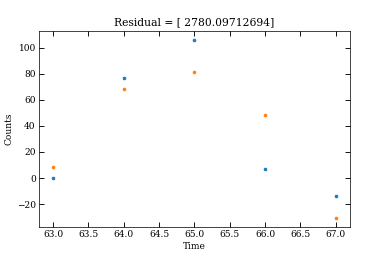

False

In [150]:
def Asteroid_fitter(Mask,Time,Data, plot = False):
    lc = np.nansum(Data*Mask,axis=(1,2))
    middle = np.where(np.nanmax(lc[Time[0]-1:Time[-1]+1]) == lc)[0][0]
    x = np.arange(middle-2,middle+2+1,1)
    x2 = np.arange(0,len(x),1)
    y = lc[[np.arange(middle-2,middle+2+1,1)]]
    p1, residual, _, _, _ = np.polyfit(x,y,2, full = True)
    p2 = np.poly1d(p1)
    maxpoly = np.where(np.nanmax(p2(x)) == p2(x))[0][0]
    print(middle)
    print(x[maxpoly])
    print(residual)
    p2 = np.poly1d(p1)
    plt.figure()
    plt.plot(x,lc[x],'.')
    plt.plot(x,p2(x),'.')
    plt.ylabel('Counts')
    plt.xlabel('Time')
    plt.title('Residual = ' + str(residual))
    if (residual < 2000) &  (abs(middle - x[maxpoly]) < 2):
        asteroid = True
    else:
        asteroid = False
        
    return asteroid 
Asteroid_fitter(eventmask[0],eventtime[0],Maskdata,True)

In [78]:
asteroid

[]

<IPython.core.display.Javascript object>


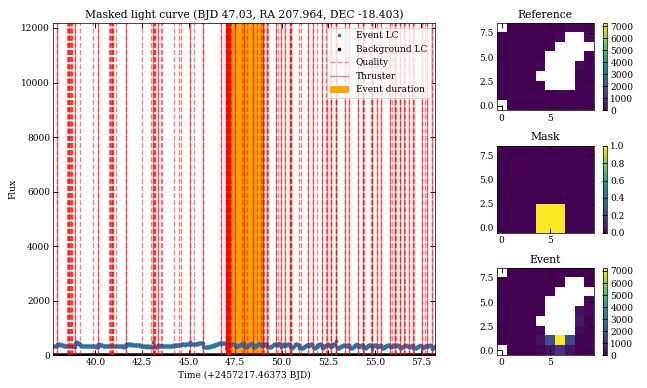

<IPython.core.display.Javascript object>


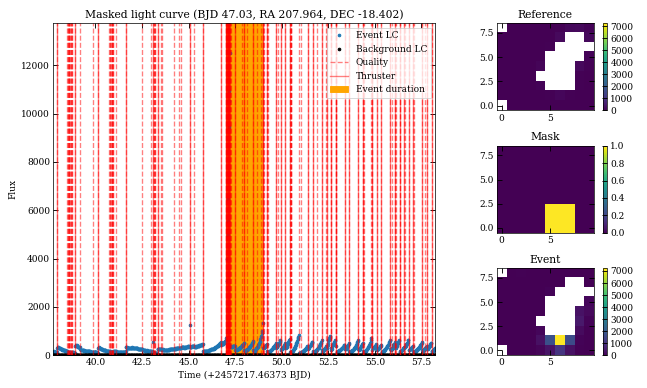

<IPython.core.display.Javascript object>


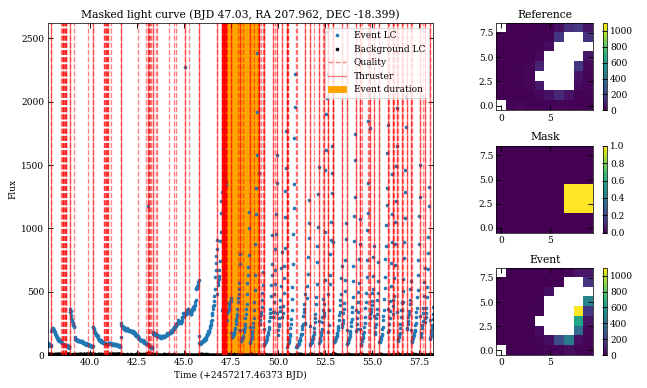

In [8]:
plt.close()
counter = 0
for i in range(len(events)):
    # Check if there are multiple transients
    #Find Coords of transient
    position = np.where(eventmask[i])
    middle = int(np.ceil(np.nansum(eventmask[i])/2))
    Coord = pix2coord(position[0][middle],position[1][middle],mywcs)

    # Generate a light curve from the transient masks
    LC = np.nansum(Maskdata*eventmask[i], axis = (1,2))
    BG = Maskdata*~Eventmask[events[i]]
    BG[BG <= 0] =np.nan
    BGLC = np.nanmedian(BG, axis = (1,2))

    maxcolor = np.nanmax(Maskdata[eventtime[i][0]:eventtime[i][-1]]*eventmask[i])

    fig = plt.figure(figsize=(10,6))
    # set up subplot grid
    gridspec.GridSpec(3,3)

    # large subplot
    plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=3)
    plt.title('Masked light curve (BJD '+str(round(time[eventtime[i][0]]-time[0],2))+', RA '+str(round(Coord[0],3))+', DEC '+str(round(Coord[1],3))+')')
    plt.xlabel('Time (+'+str(time[0])+' BJD)')
    plt.ylabel('Flux')
    plt.plot(time - time[0], LC,'.', label = 'Event LC')
    plt.plot(time - time[0], BGLC,'k.', label = 'Background LC')
    plt.axvspan(time[eventtime[i][0]]-time[0]-.5/24,time[eventtime[i][-1]]-time[0]+.5/24, color = 'orange', label = 'Event duration')
    plt.axvline(time[quality[0]]-time[0],color = 'red', linestyle='dashed',label = 'Quality', alpha = 0.5)
    for j in range(quality.shape[0]-1):
        j = j+1 
        plt.axvline(time[quality[j]]-time[0], linestyle='dashed', color = 'red', alpha = 0.5)
    # plot Thurster firings 
    plt.axvline(time[thrusters[0]]-time[0],color = 'red',label = 'Thruster', alpha = 0.5)
    for j in range(thrusters.shape[0]-1):
        j = j+1 
        plt.axvline(time[thrusters[j]]-time[0],color = 'red', alpha = 0.5)
    xmin = time[eventtime[i][0]]-time[0]-(eventtime[i][-1]-eventtime[i][0])/10
    xmax = time[eventtime[i][-1]]-time[0]+(eventtime[i][-1]-eventtime[i][0])/10
    if xmin < 0:
        xmin = 0
    if xmax > time[-1] - time[0]:
        xmax = time[-1] - time[0]
    plt.xlim(xmin,xmax) # originally 48 for some reason
    plt.ylim(0,np.nanmax(LC[eventtime[i][0]:eventtime[i][-1]])+0.1*np.nanmax(LC[eventtime[i][0]:eventtime[i][-1]]))
    plt.legend(loc = 1)
    # small subplot 1 Reference image plot
    plt.subplot2grid((3,3), (0,2))
    plt.title('Reference')
    plt.imshow(Maskdata[Framemin,:,:], origin='lower',vmin=0,vmax = maxcolor)
    plt.colorbar()
    # small subplot 2 Event mask
    plt.subplot2grid((3,3), (1,2))
    plt.title('Mask')
    plt.imshow(eventmask[i], origin='lower')
    plt.colorbar()
    # small subplot 3 Image of event
    plt.subplot2grid((3,3), (2,2))
    plt.title('Event')
    plt.imshow(Maskdata[np.where(Maskdata*eventmask[i]==np.nanmax(Maskdata[eventtime[i][0]:eventtime[i][-1]]*eventmask[i]))[0][0],:,:], origin='lower',vmin=0,vmax = maxcolor)
    plt.colorbar()
    if eventmask.shape[0] == 1 or eventmask.shape[1] == 1:
        plt.xticks([-0.5,0,0.5],['',0,''])
    # fit subplots and save fig
    fig.tight_layout()
    #fig.set_size_inches(w=11,h=7)
    plt.savefig(save+pixelfile.split('/')[-1].split('-')[0]+'_'+str(counter)+'.pdf', bbox_inches = 'tight');
    Result[3] += 1
    counter += 1


Result[0] = int(pixelfile.split('ktwo')[-1].split('-')[0])
Result[1] = (time[-1] - time[0]) - 3*len(thrusters)/48 # Last term is for removing coincident times
Result[2] = np.nansum(Mask*1)

In [117]:
asttime

[[561, 565], [561, 565], [561, 565]]

In [118]:
eventtime

array([[561, 565]])

<IPython.core.display.Javascript object>


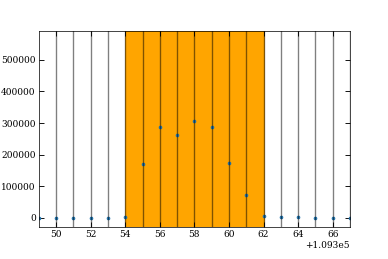

1057.03408217
468.06069068
5761.14886678


In [156]:
i=-1
plt.figure()
LongLC = np.nansum(Maskdata*eventmask[i], axis = (1,2))
plt.plot(LongLC,'.')
test = np.where(Qual!=0)[0]
for boom in thrusters:
    plt.axvline(boom,color='k',alpha = 0.5)#,alpha = .1)
plt.axvspan(eventtime[i][0],eventtime[i][-1],color='orange')
plt.xlim(eventtime[i,0]-5, eventtime[i,1]+5)

print(np.mean(LongLC[thrusters[100:350]-1]))
print(np.mean(LongLC[thrusters[100:350]+1]))
print(np.std(LongLC[thrusters[100:350]-1]))

<IPython.core.display.Javascript object>


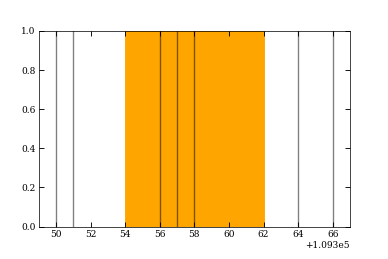

(109349, 109367)

In [158]:
i = -
plt.figure()
for boom in thrusters:
    plt.axvline(boom,color='k',alpha = 0.5)#,alpha = .1)
plt.axvspan(eventtime[i][0],eventtime[i][-1],color='orange')
plt.xlim(eventtime[i,0]-5, eventtime[i,1]+5)

In [208]:
thing = np.nansum(eventmask*Maskdata,axis = (1,2))
print(np.nanmedian(Maskdata))
print(np.nanstd(thing))
#plt.figure()
#plt.hist(LongLC,log = True)

-125.13241148
198.163662201


In [262]:
eventtime

array([[2310, 3861]])

In [ ]:
plt.figure()
plt.imshow(Maskdata[3800]/(abs(np.nanmedian(Maskdata, axis = (0))+3*(np.nanstd(Maskdata, axis = (0))))),origin = 'lower',vmax=1)
plt.colorbar()

In [229]:
Eventmask = (convolve(framemask,np.ones((1,3,3)),mode='constant', cval=0.0))*1
Eventmask = (convolve(Eventmask,np.ones((5,1,1)),mode='constant', cval=0.0) >= 4)

In [218]:
eventtime

array([[2310, 3861]])

<IPython.core.display.Javascript object>


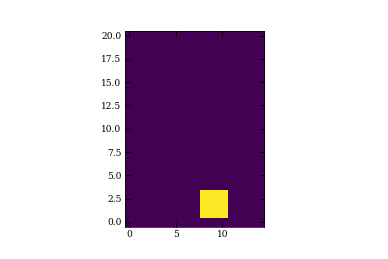

In [58]:
a = Maskdata[events[0]]
a = eventmask[1]
plt.figure()
plt.imshow(a,origin = 'lower')

<IPython.core.display.Javascript object>


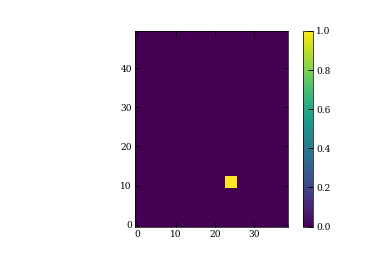

In [39]:
a = astmask[0]#Maskdata[events[0]]

plt.figure()
plt.imshow(a,origin = 'lower')
plt.colorbar()

# Animation

<IPython.core.display.Javascript object>


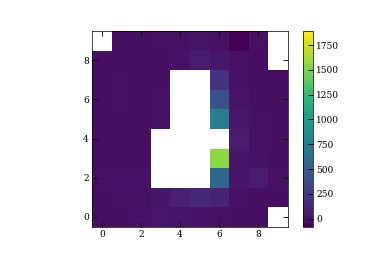

In [115]:
import matplotlib.animation as animation
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib notebook

fig = plt.figure()#figsize=(10,10))
j=0
#thingy = np.nansum(Maskdata,axis = (1,2)) != 0
test = Maskdata[asttime[j][0]+2:asttime[j][1]+20,:,:]
Maskdata2 = test#/((np.nanmedian(Maskdata, axis = (0))+3*(np.nanstd(Maskdata, axis = (0))))))>=1#[Framemin::12]
im = plt.imshow(Maskdata2[0,:,:], origin='lower', animated=True)
i = 0
def updatefig(*args):
    global i
    if i<Maskdata2.shape[0]+1:
        i+=1
        
    im.set_array(Maskdata2[i])
    return im,

ani = animation.FuncAnimation(fig, updatefig, interval=60, blit=True)
plt.colorbar();
#ani.save(save+pixelfile.split('/')[-1].split('-')[0]+'_'+'.gif',writer='imagemagick');
#plt.figure()
#plt.imshow(eventmask[j],origin='lower')


In [38]:
asteroid

array([ 3461.])

In [24]:
eventtime

array([[3579, 3603],
       [3579, 3601]])

In [364]:
testlc = np.nansum(datacube*obj,axis=(1,2))
testlc = datacube[:,6,2]
teststd = np.nanstd(testlc[Qual==0])
testmed = np.nanmedian(testlc[Qual==0])
print(testmed)
print(teststd/testmed)

5.19621
4.18708


<IPython.core.display.Javascript object>


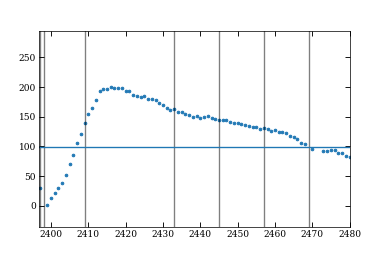

(2370, 2550)

In [370]:
plt.figure()
plt.plot(testlc,'.')
for boom in thrusters:
    plt.axvline(boom,color='k',alpha = 0.5)#,alpha = .1)
plt.axhline(np.nanmedian(testlc)+3*np.nanstd(testlc))
#plt.axhline(np.nansum(testmed+teststd))
plt.xlim(2370,2550)

In [396]:
np.where(testlc == np.nanmax(testlc))

(array([144]),)

<IPython.core.display.Javascript object>


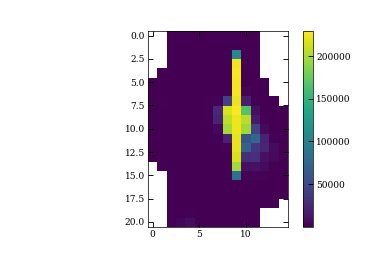

In [46]:
plt.figure()
plt.imshow(datacube[events[1]])

plt.colorbar()


In [421]:
np.nanmax(datacube[events[0]])

198889.53

## test data


In [28]:
testtime = np.arange(2592,3000)
def LongTest(x, bright, stretch, disp):
    x = np.arange(0,x)
    y = -stretch*(x-disp)**2 + bright
    y[y<0] = 0
    return y

<IPython.core.display.Javascript object>


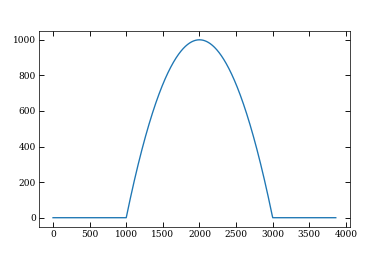

In [426]:
plt.figure()
plt.plot(LongTest(time.shape[0], 1000, .001, 2000));

In [427]:
testdata = fits.ImageHDU(hdu[1].data.field('FLUX')[:]).data
testdata[testtime,6,6] = LongTest(time.shape[0], 1000, .001, 2000)[testtime]
testdata[1000:1005,1,1] = 40

## Attempt at primative centroiding

In [248]:
right = np.c_[np.zeros((obj.shape[0],1)),np.delete(obj*1,obj.shape[1]-1,1)]
left = np.c_[np.delete(obj*1,0,1),np.zeros((obj.shape[0],1))]
up = np.r_[np.delete(obj*1,0,0),np.zeros((1,obj.shape[1]))]
down = np.r_[np.zeros((1,obj.shape[1])),np.delete(obj*1,obj.shape[0]-1,0)]
directions = np.array((obj,right,left,up,down))

In [249]:
directions.shape

(5, 8, 9)

In [251]:
np.nanmin(abs(np.nansum(directions*datacube[events[0]],axis = (1,2)) - np.nansum(obj*datacube[events[0]],axis = (0,1))),axis = 0 )

0.0009307861328125

In [253]:
np.nansum(directions*datacube[events[0]],axis = (1,2)) - np.nansum(obj*datacube[events[0]],axis = (0,1))

array([  9.30786133e-04,   1.22797411e+03,  -1.60563488e+04,
         1.62519852e+03,  -9.56835416e+03])

<IPython.core.display.Javascript object>


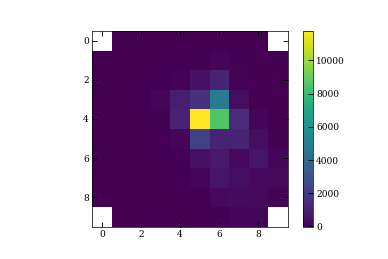

In [98]:
plt.figure()
plt.imshow(datacube[events[0]])#*up)
plt.colorbar();

In [139]:
test1 = abs(Maskdata[thrusters+1]-Maskdata[thrusters-1])
test = np.copy(test1)
test[(test > 100)] = np.nan

<IPython.core.display.Javascript object>


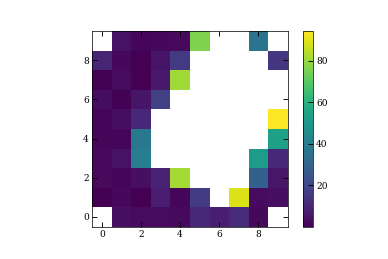

<IPython.core.display.Javascript object>


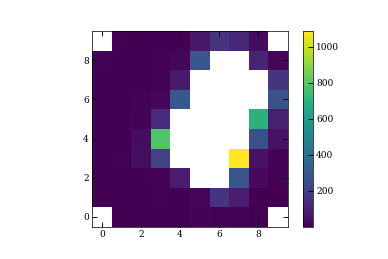

In [140]:
i = 1
plt.figure()
plt.imshow(test[i],origin='lower')
plt.colorbar()
plt.figure()
plt.imshow(test1[i],origin='lower')
plt.colorbar()

In [226]:
def DriftKiller(Data,thrust):
    # The right value choice here is a bit ambiguous, though it seems that typical variations are <10.
    data = np.copy(Data)
    data[np.isnan(data)] == 0
    Drift = (abs(convolve(data[thrust+1],np.ones((1,3,3)),mode='constant', cval=0.0)-convolve(data[thrust-1],np.ones((1,3,3)),mode='constant', cval=0.0))) < 90    
    Drift = Drift*1.0
    Drift[Drift == 0] = np.nan
    j = 0
    for i in range(len(thrust)):
        data[j:thrust[i]] = data[j:thrust[i]]*Drift[i]
        j = thrust[i]
    return data


In [181]:
Drift = (abs(Maskdata[thrusters+1]-Maskdata[thrusters-1]) < 10)*1.0 
Drift[Drift == 0] = np.nan
j = 0
testdata = np.copy(Maskdata)
for i in range(len(thrusters)):
    testdata[j:thrusters[i]] = testdata[j:thrusters[i]]*Drift[i]
    j = thrusters[i]

In [182]:
Drift[Drift == 0] = np.nan


In [185]:
np.where(Drift==0)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

<IPython.core.display.Javascript object>


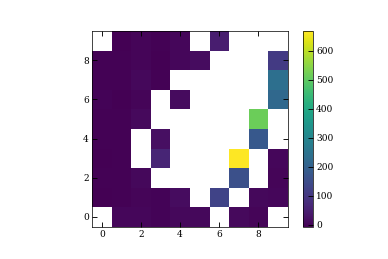

In [195]:
plt.figure()
plt.imshow(Maskdata[20]*Drift[20],origin='lower')
plt.colorbar()

In [227]:
test = DriftKiller(Maskdata,thrusters)

<IPython.core.display.Javascript object>


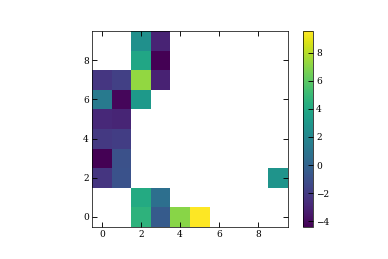

<IPython.core.display.Javascript object>


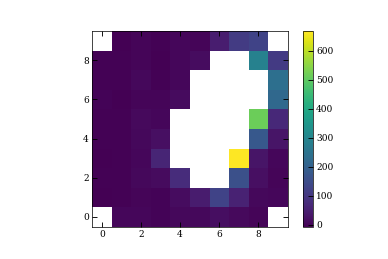

In [228]:
i = 20
plt.figure()
plt.imshow(test[i],origin='lower')
plt.colorbar()
plt.figure()
plt.imshow(Maskdata[i],origin='lower')
plt.colorbar()

<IPython.core.display.Javascript object>


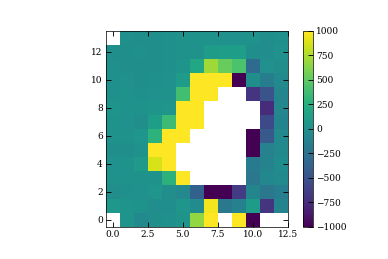

In [63]:
plt.figure()
plt.imshow(Maskdata[thrusters[7]-1]-Maskdata[thrusters[7]+1],origin='lower',vmin=-1000,vmax=1000)
plt.colorbar()

<IPython.core.display.Javascript object>


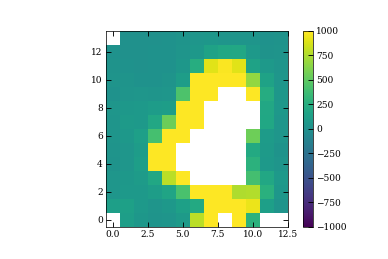

In [64]:
plt.figure()
plt.imshow(Maskdata[thrusters[7]-1],origin='lower',vmin=-1000,vmax=1000)
plt.colorbar()

In [59]:
Qual[3644]

10240

<IPython.core.display.Javascript object>


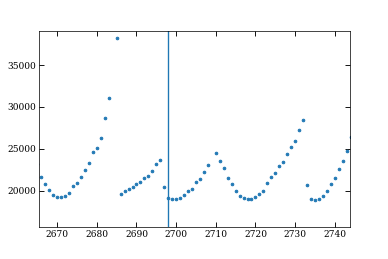

In [75]:
plt.figure()
plt.plot(np.nansum(Maskdata*Eventmask[events[0]], axis = (1,2)),'.')
"""for i in thrusters:
    plt.axvline(i)"""

def MinThrustframe(data,thrust):
    mean = np.nanmean(data[thrust+1],axis = 0)
    std = np.nanstd((data[thrust+1] - mean), axis = (1,2))
    Framemin = np.where(std == np.nanmin(abs(std)))
    return thrust[Framemin]+1
plt.axvline(MinThrustframe(datacube,thrusters))
#plt.xlim(800,1200);

## Looking at variations on a single pixel


<IPython.core.display.Javascript object>


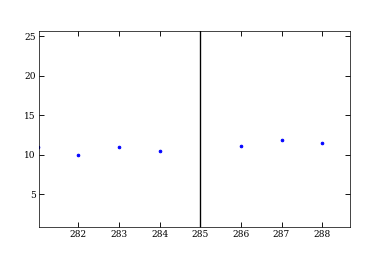

In [122]:
testLC = datacube[:,2,2]

plt.figure()
plt.plot(testLC,'.b')
for i in thrusters:
    plt.axvline(i,color = 'black')

In [123]:
np.nanstd(datacube[:,2,2])

11.5839